In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import sys
sys.path.append('..')

from jax import numpy as jnp
import jax
import time
from scipy.integrate import quad, dblquad
import equinox as eqx
import jax_cosmo as jc
from quadax import quadgk, quadcc, quadts, romberg
from functools import partial

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation 
from numpy import loadtxt
from diffrax import Kvaerno5, Tsit5
%matplotlib inline

from plot_params import params
#pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.reactions import Reaction
from linx.thermo import T_g 
from linx.const import mn, mp, eta0, hbar, me, aFS, NE_pd, NE_min
from scipy.integrate import odeint, solve_ivp, simpson, cumulative_simpson
from linx.pd_rates import decay_model
from linx.injected_spec import InjectedSpectrum
eps = 1e-3
Emin = 1.5 # MeV
Ephb_T_max = 200

In [5]:
bkg_model = BackgroundModel()
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.), T_end = 1e-4, max_steps = 512*4)

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


/home/mkwok/miniconda3/envs/linx/lib/python3.13/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


In [6]:
InjSpec = InjectedSpectrum()
#E_grid = jnp.linspace(1.5, jnp.exp(3), 100)

In [7]:
mod = decay_model(60, 1e5, 5e-7, 1, 0, t_vec, a_vec, rho_g_vec)

## Timing

In [8]:
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(5), 150, base=jnp.e)

# Generate the grid for the different species
X_grid = jnp.arange(3)

In [10]:
def testing_loop(E_grid, X_grid):
    return jnp.array([[InjSpec.rate_x(X, E, 0.01) for E in E_grid] for X in X_grid])

%timeit testing_loop(E_grid, X_grid).block_until_ready()

1.42 s ± 312 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
ii, jj = jnp.meshgrid(X_grid, E_grid, indexing='ij')

@jax.jit
def testing(ii, jj):
    return jnp.reshape(jax.vmap(InjSpec.rate_x, in_axes=(0, 0, None))(ii.flatten(), jj.flatten(), 0.01), (3, 150))
    
%timeit testing(ii, jj).block_until_ready()

2.97 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
f1 = jax.vmap(InjSpec.rate_x, in_axes=(0, None, None))
f2 = jax.vmap(f1, in_axes=(None, 0, None))
@jax.jit
def testing2(X_grid, E_grid):
    return f2(X_grid, E_grid, 0.001)
    
%timeit testing2(X_grid, E_grid).block_until_ready()

179 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
testing2(X_grid, E_grid).shape

(10, 3)

In [65]:
ii, jj, kk, ll = jnp.meshgrid( X_grid, X_grid,E_grid, E_grid,indexing='ij')
k = jnp.stack([ll, kk, jj, ii], axis=-1)
k_true = jnp.array(k[:, :, :, :, 0] >= k[:, :, :, :, 1])

@jax.jit
def testing3():
    return jax.vmap(InjSpec.kernel_x, in_axes=(0, 0, 0, None, 0))(ii.flatten(), jj.flatten(), kk.flatten(), 0.001, ll.flatten())

g1 = jax.vmap(InjSpec.kernel_x, in_axes=(None, None, None, None, 0))
g2 = jax.vmap(g1, in_axes=(None, None, 0, None, None))
g3 = jax.vmap(g2, in_axes=(None, 0, None, None, None))
g4 = jax.vmap(g3, in_axes=(0, None, None, None, None))

def testing4():
    return g4(X_grid, X_grid, E_grid, 0.001, E_grid)

In [14]:
%timeit testing3().block_until_ready()

476 ms ± 8.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%timeit testing4().block_until_ready()

80.3 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
testing4().shape

(3, 3, 10, 10)

In [59]:
K2 = testing4()

In [26]:
E0, S_0f, S_contf, T = 30, mod.get_source_0(), mod.get_source_cont(), 0.001
NE = jnp.array(jnp.log10(E0/Emin)*NE_pd, int)
NE = jnp.maximum(NE, NE_min)
NE = 10

#number of species
N_X = 3

E_grid = jnp.logspace(jnp.log(Emin), jnp.log(E0), NE, base=jnp.e)

# Generate the grid for the different species
X_grid = jnp.arange(N_X)

#rate (MeV)
t1 = time.time()
#ii, jj = jnp.meshgrid(X_grid, E_grid, indexing='ij')
#R = jnp.reshape(jax.vmap(self.rate_x, in_axes=(0, 0, None))(ii.flatten(), jj.flatten(), T), (N_X, NE))
#R = jnp.reshape(self.rate_x(ii.flatten(), jj.flatten(), T), (N_X, NE))
R = jnp.array([[InjSpec.rate_x(X, E, T) for E in E_grid] for X in X_grid])
#R = jnp.array([self.rate_x(X_grid, E, T) for E in E_grid])

t2 = time.time()
print("Rate time: ", t2-t1)

ii, jj, kk, ll = jnp.meshgrid( X_grid, X_grid,E_grid, E_grid,indexing='ij')
k = jnp.stack([ll, kk, jj, ii], axis=-1)
k_true = jnp.array(k[:, :, :, :, 0] >= k[:, :, :, :, 1])
K = jnp.select([k_true], [jnp.reshape(jax.vmap(InjSpec.kernel_x, in_axes=(0, 0, 0, None, 0))(ii.flatten(), jj.flatten(), kk.flatten(), T, ll.flatten()), (N_X, N_X, NE, NE))])
t3 = time.time()

print("Kernel time: ", t3-t2)
#K = jnp.select([k_true], [jnp.array([[[[self.kernel_x(X, X_out, E, T, Ep) for Ep in E_grid] for E in E_grid] for X_out in X_grid] for X in X_grid])])
#K = jnp.array([[[[self.kernel_x(X, X_out, E, T, Ep) if Ep >= E else 0. for Ep in E_grid] for E in E_grid] for X_out in X_grid] for X in X_grid])

S_0 = jnp.array([S0X(T) for S0X in S_0f])
S_cont = jnp.array([[SCX(E, T) for E in E_grid] for SCX in S_contf])
t4 = time.time()
dy = jnp.log(E_grid[-1]/Emin)/(NE-1)

Rate time:  0.15887451171875
Kernel time:  0.520820140838623


For $i \in \{0, 1, ..., N\}$, we have
$$
\Gamma_x(\epsilon_i) F_x(\epsilon_i) = S^{(FSR)}_x(\epsilon_i) + 
\sum_{x'} \left[ \frac{K_{x' \to x}(\epsilon_i, E_0) S^{(0)}_{x'}}{\Gamma_{x'}(E_0)} + 
\int_{\ln(\epsilon_i)}^{\ln(E_0)} dy\, e^y K_{x' \to x}(\epsilon_i, e^y) F_{x'}(e^y) \right]
$$

Using the trapezoidal rule, the integral part becomes


$$
 \Delta y \left( \frac{\epsilon_i K_{x' \to x}(\epsilon_i, \epsilon_i) F_{x'}(\epsilon_i) + E_0 K_{x' \to x}(\epsilon_i, E_0) F_{x'}(E_0)}{2} 
+ \sum_{j = 1+1}^{N -1} \epsilon_j K_{x' \to x}(\epsilon_i, \epsilon_j) F_{x'}(\epsilon_j) \right ) 
$$

This will be cast into a matrix equation $\Gamma_x(\epsilon_i) F_x(\epsilon_i) = a + B F_x(\epsilon_i)$ so we can obtain $F_x(\epsilon_i)$ by solving
$$
(\Gamma_x(\epsilon_i)-B) F_x(\epsilon_i) =  a
$$
where 
$$
a = S^{(FSR)}_x(\epsilon_i) + 
\sum_{x'}  \frac{K_{x' \to x}(\epsilon_i, E_0) S^{(0)}_{x'}}{\Gamma_{x'}(E_0)} 
$$

$B$ can be split up into three parts. The first part is the energy multiplied by the trace of $K$, which is a diagonal matrix:

\begin{equation}
\rm{diag}(B_0) = \frac{\Delta y}{2}
\begin{pmatrix}
\epsilon_0 K_{0, 0} & \epsilon_1 K_{1, 1} & \dots & \epsilon_N K_{N, N}
\end{pmatrix}
\end{equation}

The second is the last column, which is 
\begin{equation}
\begin{split} B_{last}
&= \frac{\Delta y}{2}
\begin{pmatrix}
0& 0 & \dots & E_0 K_{0, E_0}  + E_0 K_{i, E_0} + E_0 K_{2, E_0}
\end{pmatrix}^T \\
&= \frac{\Delta y}{2} \begin{pmatrix}
0& 0 & \dots& \sum_{j = 0}^N E_0 K_{j, E_0}
\end{pmatrix}^T
\end{split}
\end{equation}

<!---
Lastly, we have the sum part:


\begin{equation}
B_{sum} = 
\begin{pmatrix}
0 & \epsilon_1 K_{0, 1} & \epsilon_2 K_{0, 2} + \epsilon_2 K_{1, 2} & \epsilon_3 K_{0, 3} + \epsilon_3 K_{1, 3} + \epsilon_3 K_{2, 3} & \dots & \sum_{j = 1}^{N-1} \epsilon_j K_{i, N-1} & 0
\end{pmatrix}
\end{equation}
-->

The final B matrix will be



\begin{equation}
\begin{pmatrix}
\Gamma(\epsilon_0)       & 0                    & \dots & 0 & 0 \\
0                        & \Gamma_x(\epsilon_2) & \dots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots &  \Gamma(\epsilon_{N-1}) & 0 \\
0 & 0 & \dots & 0 & \Gamma(\epsilon_{N})
\end{pmatrix}

- \frac{\Delta y}{2}

\begin{pmatrix}
\epsilon_0 K_{0, 0} & 2 \epsilon_1 K_{0, 1} & 2 \epsilon_2 K_{0, 2} &  \dots &  2 \epsilon_{N-1} K_{0, N-1} &  E_0 K_{0, N} \\
0                   & \epsilon_1 K_{1, 1}   & 2 \epsilon_2 K_{1, 2} &  \dots &  2 \epsilon_{N-1} K_{1, N-1} &  E_0 K_{1, N} \\
0              &      0                &   \epsilon_2 K_{2, 2} &  \dots &  2 \epsilon_{N-1} K_{2, N-1} &  E_0 K_{2, N} \\
\vdots              &                       &                       &  \ddots&                         & \vdots        \\
0                   &    0                  &         0             &  \dots &    \epsilon_{N-1} K_{N-1,N-1}& E_0 K_{N-1, N} \\
0                   &        0              &         0             &  \dots &        0                     & 0
\end{pmatrix}
\end{equation}

In [62]:
K

Array([[[[3.87111652e-23, 1.96152451e-23, 1.21036845e-23,
          9.51622507e-24, 1.02058639e-23, 1.49227885e-23,
          2.65208767e-23, 5.09513403e-23, 9.95285920e-23,
          1.92923076e-22],
         [0.00000000e+00, 2.07361902e-23, 1.13701802e-23,
          8.20835233e-24, 8.62183537e-24, 1.29693452e-23,
          2.39262094e-23, 4.73327299e-23, 9.44057594e-23,
          1.85717151e-22],
         [0.00000000e+00, 0.00000000e+00, 1.22898425e-23,
          7.94781389e-24, 7.73905306e-24, 1.14204677e-23,
          2.13827013e-23, 4.32892064e-23, 8.82067837e-23,
          1.76560474e-22],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.47883795e-24, 8.00366824e-24, 1.06393349e-23,
          1.92120163e-23, 3.90581266e-23, 8.09975633e-23,
          1.65233165e-22],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.09844847e-23, 1.16121086e-23,
          1.82141525e-23, 3.53320257e-23, 7.32857153e-23,
          1.51899905e-

In [61]:
jnp.triu(K2)

Array([[[[3.87111652e-23, 1.96152451e-23, 1.21036845e-23,
          9.51622507e-24, 1.02058639e-23, 1.49227885e-23,
          2.65208767e-23, 5.09513403e-23, 9.95285920e-23,
          1.92923076e-22],
         [0.00000000e+00, 2.07361902e-23, 1.13701802e-23,
          8.20835233e-24, 8.62183537e-24, 1.29693452e-23,
          2.39262094e-23, 4.73327299e-23, 9.44057594e-23,
          1.85717151e-22],
         [0.00000000e+00, 0.00000000e+00, 1.22898425e-23,
          7.94781389e-24, 7.73905306e-24, 1.14204677e-23,
          2.13827013e-23, 4.32892064e-23, 8.82067837e-23,
          1.76560474e-22],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.47883795e-24, 8.00366824e-24, 1.06393349e-23,
          1.92120163e-23, 3.90581266e-23, 8.09975633e-23,
          1.65233165e-22],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.09844847e-23, 1.16121086e-23,
          1.82141525e-23, 3.53320257e-23, 7.32857153e-23,
          1.51899905e-

In [64]:
jnp.triu(K2)/K

Array([[[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1.],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.]],

        [[nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.],
         [nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
         [nan, nan, na

In [112]:
dy = jnp.log(E_grid[-1]/Emin)/(NE-1)

I_3310 = jnp.repeat(jnp.repeat(jnp.identity(3), NE, axis=1), NE, axis=1).reshape((3, 3, NE, NE))

B_diag = jnp.tril(jnp.triu(K/2*dy*E_grid + R[:, None, :, None]*I_3310))

B_last = -dy*E_grid[-1]*K[:, :, :, -1]/2
B_last = B_last.at[:, :, -1].set(0)

B = jnp.concatenate((K[:, :, :, :-1], B_last[:,:, :, None]), axis = 3)
B = (B_diag - dy*K*E_grid)
a = S_cont + jnp.einsum("ijk,j", K[:, :, :, -1], S_0/R[:, -1])

In [118]:
jnp.linalg.tensorsolve(B, a, axes =(0, 3))

Array([[7.47128012e-23, 7.00349504e-25, 1.70992759e-26, 3.79300729e-28,
        8.12900183e-30],
       [1.69749537e-27, 1.00809501e-28, 8.44694140e-30, 2.60845564e-30,
        0.00000000e+00],
       [1.69749537e-27, 1.00809501e-28, 8.44694140e-30, 2.60845564e-30,
        0.00000000e+00]], dtype=float64)

In [116]:
InjSpec = InjectedSpectrum()
sp = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)
sp

Rate time:  1.5103230476379395
Kernel time:  0.1481480598449707
Source time:  0.013219833374023438
Solve time:  0.01090693473815918


Array([[1.50000000e+00, 2.02680023e+00, 2.73861279e+00, 3.70041402e+00,
        5.00000000e+00],
       [1.03674917e-22, 8.35449261e-25, 1.76082252e-26, 3.79300728e-28,
        8.12900183e-30],
       [6.02755995e-30, 3.10309147e-30, 2.43285307e-30, 2.33434598e-30,
        4.05996516e-40],
       [6.02375505e-30, 3.10305917e-30, 2.43285234e-30, 2.33434596e-30,
        0.00000000e+00]], dtype=float64)

In [111]:
InjSpec = InjectedSpectrum()
sp = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)
sp

Rate time:  10.76305866241455
Kernel time:  3.7252440452575684
Source time:  0.33133888244628906
Solve time:  0.16017961502075195


Array([[1.50000000e+000, 2.02680023e+000, 2.73861279e+000,
        3.70041402e+000, 5.00000000e+000],
       [1.03519554e-022, 8.34928072e-025, 1.76063104e-026,
        3.79300659e-028, 8.12898254e-030],
       [6.00021510e-030, 3.07237428e-030, 2.40752876e-030,
        2.32581517e-030, 1.00000000e-200],
       [5.99641586e-030, 3.07234200e-030, 2.40752802e-030,
        2.32581515e-030, 1.00000000e-200]], dtype=float64)

In [157]:
dy = jnp.log(E_grid[-1]/Emin)/(NE-1)

#First term of sum
B_0 = E_grid*jnp.diagonal(K, axis1 = 2, axis2 = 3)/2
B_last = jnp.sum(E_grid[-1]*K[:, :, :, -1], axis = 2)/2
#coefficients for within integral
#B_j = jnp.sum(K[:, :, : , 1:NE-1], axis = 2)* E_grid[1:NE-1]
#B_j = jnp.pad(B_j, ((0, 0), (0, 0), (1, 0)), mode = 'constant')
B_j = jnp.dstack((jnp.zeros((3, 3)), B_j, B_last))
I_10 = jnp.repeat(jnp.identity(3), NE, axis=1).reshape((3, 3, NE))
B = R*I_10 - dy*(B_0 + B_j)

a = S_cont + jnp.einsum("ijk,j", K[:, :, :, -1], S_0/R[:, -1])

TypeError: add got incompatible shapes for broadcasting: (3, 3, 10), (3, 3, 12).

In [49]:
solved = jnp.transpose(jnp.linalg.solve(B, a))
solved

ValueError: inconsistent size for core dimension 'm': 10 vs 3 on vectorized function with excluded=frozenset() and signature='(m,m),(m,n)->(m,n)'

In [50]:
solved = jnp.transpose(jnp.linalg.solve(B.transpose(), a.transpose()))
solved

ValueError: inconsistent size for core dimension 'm': 3 vs 10 on vectorized function with excluded=frozenset() and signature='(m,m),(m,n)->(m,n)'

## Solver with loop

In [27]:
FX_E0 = S_cont[:, -1]/R[:, -1] + jnp.sum(jnp.einsum("ij, j", K[:, :, -1, -1], S_0/R[:, -1])/R[:, -1])
I_10 = jnp.repeat(jnp.identity(3), NE, axis=1).reshape((3, 3, NE))
B = -.5*dy* E_grid*jnp.diagonal(K, axis1 = 2, axis2 = 3) + R*I_10
#B = B.at[-1, 0, :].set(0)
a = S_cont + jnp.einsum("ijk,j", K[:, :, :, -1], S_0/R[:, -1]) + .5*dy*E_grid[-1] * jnp.einsum("ijk,j", K[:, :, :, -1], FX_E0)

In [28]:
F = jnp.zeros((3, NE))
F = F.at[:, -1].set(FX_E0)

In [29]:
for i in range(0, 8):
    j = 8-i
    #a_j = dy*E_grid[j:-1]* jnp.einsum("ijk,j", K[:,:,:,j:-1]*F[:,j:-1])
    a_j = jnp.einsum("ijk,jk", dy*E_grid[j:-1]*K[:,:,j-1,j:-1], F[:,j:-1])
    F = F.at[:, j-1].set(jnp.linalg.solve(B[:,:,j-1], a[:,j-1] + a_j))


In [30]:
F

Array([[1.03519554e-22, 8.34928072e-25, 1.76063104e-26, 3.79300659e-28,
        8.12902113e-30],
       [6.00021510e-30, 3.07237428e-30, 2.40752876e-30, 2.32581517e-30,
        8.11993032e-40],
       [5.99641586e-30, 3.07234200e-30, 2.40752802e-30, 2.32581515e-30,
        0.00000000e+00]], dtype=float64)

In [15]:
jnp.linalg.solve(B[:, :, 0], a[:, 0])

Array([7.41685389e-23, 2.67438188e-31, 2.67438188e-31], dtype=float64)

In [136]:
solved = jnp.transpose(jnp.linalg.solve(B.transpose(), a.transpose()))
solved

Array([[ 7.45457381e-23, -5.33222619e-27, -5.71881341e-27,
         3.86753455e-28, -8.19780658e-30],
       [ 2.66244864e-31, -2.36172635e-27, -1.36726121e-27,
         1.37795802e-29, -7.26759488e-30],
       [ 2.66244864e-31, -2.36172635e-27, -1.36726121e-27,
         1.37795802e-29, -7.26759488e-30]], dtype=float64)

In [119]:
K_pad = jnp.pad(K[:, :, 1:NE-1, 1:NE-1], ((0, 0), (0, 0), (1, 1), (1, 1)), 'constant')
E_pad = jnp.pad(E_grid[1:NE-1], (1, 1), 'constant')
B2 = jnp.einsum("ijkl, l", K_pad, E_pad)
dy = jnp.log(E_grid[-1]/Emin)/(NE-1)
I_10 = jnp.repeat(jnp.identity(3), NE, axis=1).reshape((3, 3, NE))
B = -.5*dy* E_grid*jnp.diagonal(K, axis1 = 2, axis2 = 3) + R*I_10 - dy*B2
a = S_cont + jnp.einsum("ijk,j", K[:, :, :, -1], S_0/R[:, -1]) + .5*dy*E_grid[-1] * jnp.einsum("ijk,j", K[:, :, :, -1], FX_E0)


In [149]:
E_T = jnp.logspace(-3, 1 , 1000)
fp_fd = 1/(jnp.exp(E_T) + 1)
fp_be = 1/(jnp.exp(E_T) - 1)
fp_mb = 1/(jnp.exp(E_T))
dist_fd = fp_fd*E_T**2 /(2*jnp.pi**2)
dist_be = fp_be*E_T**2 /(2*jnp.pi**2)
dist_mb = fp_mb*E_T**2 /(2*jnp.pi**2)

In [157]:
def avg_value(dist):
    return jnp.trapezoid(dist[:]*E_T[:],E_T[:])/jnp.trapezoid(dist, E_T)

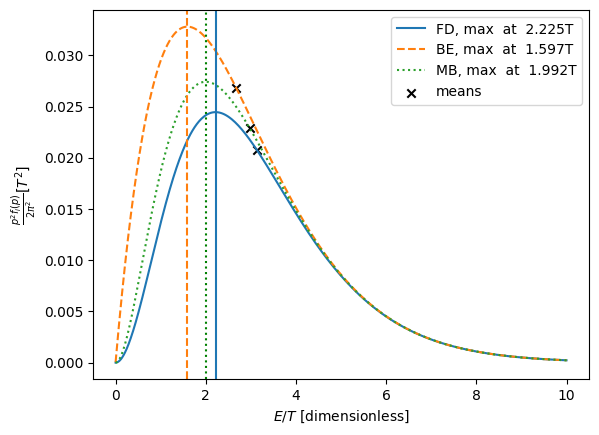

In [193]:
plt.plot(E_T, dist_fd, label = f'FD, max  at {E_T[jnp.argmax(dist_fd)]: .3f}T')
plt.plot(E_T, dist_be, label = f'BE, max  at {E_T[jnp.argmax(dist_be)]: .3f}T', linestyle = '--')
plt.plot(E_T, dist_mb, label = f'MB, max  at {E_T[jnp.argmax(dist_mb)]: .3f}T', linestyle = ':')
plt.xlabel(r"$E/T$ [dimensionless]")
plt.ylabel(r"$\frac{p^2 f_i(p)}{2 \pi^2} [T^2]$")
plt.axvline(2.219966119119955, color = 'tab:blue')
plt.axvline(1.5929502125721224, color = 'tab:orange', linestyle = '--')       
plt.axvline(2.001249798969037, color = 'green', linestyle = ":") 
plt.scatter(avg_value(dist_fd), jnp.interp(avg_value(dist_fd), E_T, dist_fd), color = 'k', marker='x', label = "means")
plt.scatter(avg_value(dist_be), jnp.interp(avg_value(dist_be), E_T, dist_be), color = 'k', marker='x')
plt.scatter(avg_value(dist_mb), jnp.interp(avg_value(dist_mb), E_T, dist_mb), color = 'k', marker='x')
plt.legend()
plt.show()

In [177]:
print("fd: ", jnp.max(dist_fd))
print("be: ", jnp.max(dist_be))
print("mb: ", jnp.max(dist_mb))

fd:  0.024460128974180474
be:  0.03280824889600686
mb:  0.02742422722727643


In [192]:
print(avg_value(dist_fd), jnp.interp(avg_value(dist_fd), E_T, dist_fd))
print(avg_value(dist_be), jnp.interp(avg_value(dist_be), E_T, dist_be))       
print(avg_value(dist_mb), jnp.interp(avg_value(dist_mb), E_T, dist_mb))

3.126574158026763 0.020811616114938813
2.6815518302313555 0.02677036592891449
2.9772272848523547 0.022871579470382753


In [32]:
mod.pd_tables

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float64)

In [10]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='pd_PRIMAT_2023', pd_model= mod)
)

nuclear_rates_q = jnp.zeros(12)

sol = abd_model(
    rho_g_vec, rho_nu_vec, 
    rho_NP_vec, p_NP_vec,
    t_vec=t_vec, a_vec=a_vec, 
    eta_fac = jnp.asarray(1.), 
    tau_n_fac = jnp.asarray(1.), 
    nuclear_rates_q = nuclear_rates_q,
    save_history=True, T_end = 1e-4, max_steps = 4096*2, solver = Kvaerno5())

new_abundances = jnp.array([sol.evaluate(t) for t in t_vec])


Compiling abundance model...


In [13]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='key_PRIMAT_2023')
)

nuclear_rates_q = jnp.zeros(12)

sol = abd_model(
    rho_g_vec, rho_nu_vec, 
    rho_NP_vec, p_NP_vec,
    t_vec=t_vec, a_vec=a_vec, 
    eta_fac = jnp.asarray(1.), 
    tau_n_fac = jnp.asarray(1.), 
    nuclear_rates_q = nuclear_rates_q,
    save_history=True, T_end = 1e-4, max_steps = 4096*2, solver = Kvaerno5())

old_abundances = jnp.array([sol.evaluate(t) for t in t_vec])

Compiling abundance model...


In [20]:
T_g_vec = T_g(rho_g_vec)

def t_to_T(t):
    
    return jnp.interp(t, t_vec, T_g_vec, left=T_g_vec[0]*2, right=T_g_vec[-1]/2)

def T_to_t(T):

    return jnp.interp(T, jnp.flip(T_g_vec), jnp.flip(t_vec), left=t_vec[-1]/2, right=t_vec[0]*2)

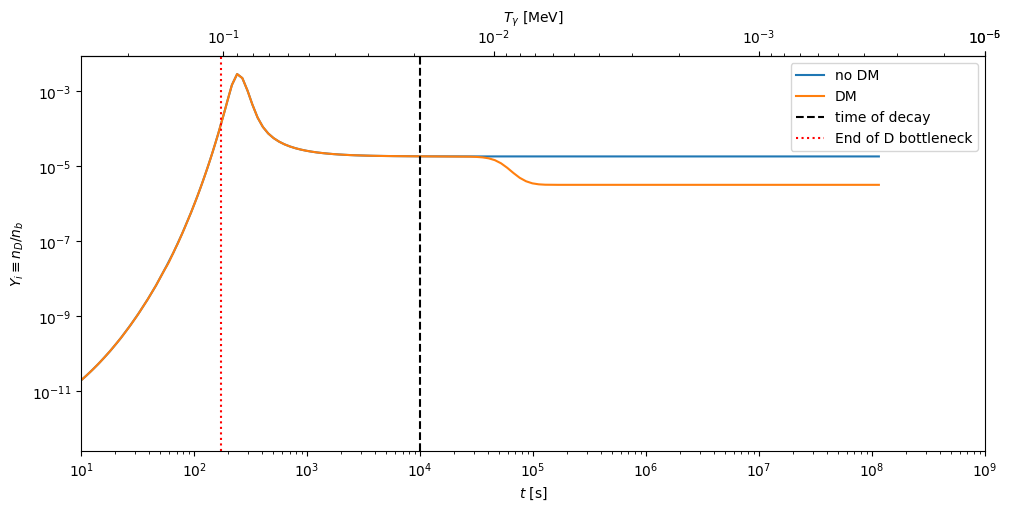

In [44]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

'''for i in range(8):
    ax.loglog(t_vec, new_abundances[:, i], label = 'DM')
    ax.loglog(t_vec, old_abundances[:, i], label = 'no DM')
'''
ax.loglog(t_vec, old_abundances[:, 2], label = 'no DM')
ax.loglog(t_vec, new_abundances[:, 2], label = 'DM')
ax.axvline(1e4, label = r'time of decay', color = 'k', linestyle = '--')

ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$Y_i \equiv n_D / n_b$')
ax.axvline(T_to_t(0.085), color='r', ls=':', label = "End of D bottleneck")
secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')
ax.set_xlim(10, 1e9)

plt.legend()

In [98]:
import numpy as np

a = np.eye(2*3*4)

a.shape = (2*3, 4, 2, 3, 4)

rng = np.random.default_rng()

b = rng.normal(size=(2*3, 4))
print(a.shape, b.shape)
x = np.linalg.tensorsolve(a, b)

x.shape


(6, 4, 2, 3, 4) (6, 4)


(2, 3, 4)